## This notebook applies negative error probabilities using the Monte-Carlo sampling, where initial error probabilities are learned using Qiskit noise characterization. 

In [1]:
import pennylane as qml
import qutip as qt
# from qutip import qzero
from qutip import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [2]:
N = 3
J = np.zeros((N,N))
edge_2q = ([]) 
jp = [1, 0, 1]
kas = 0
for i in range(N):
    for j in range(N):
        if j>i:
            edge_2q.append((i,j))
            # J[i][j] =np.round(np.random.uniform(-1,1),2) # Generating random J_ij accroding to the seed number
            J[i][j] = jp[kas]
            kas+=1

print(edge_2q)
print(jp)
# print(edge_nn)

n_wires = N
graph = graph1 =edge_2q 
dev = qml.device('default.qubit', wires=n_wires)

print("Jij =",jp)

[(0, 1), (0, 2), (1, 2)]
[1, 0, 1]
Jij = [1, 0, 1]


In [3]:
# pre-allocate operators (Pauli-X,-Y,-Z,-I)
si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

si_list = []
sx_list = []     
sy_list = []
sz_list = []

op_list = []
for m in range(N):
    op_list.append(si)
    
si_list.append(qt.tensor(op_list))

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sz
    sz_list.append(qt.tensor(op_list))


for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sy
    sy_list.append(qt.tensor(op_list))
    
for n in range(N):
    op_list = []
    
    for m in range(N):
        op_list.append(si)
        
    op_list[n] = sx
    sx_list.append(qt.tensor(op_list))

H_ij = 0
k = 0 
for edge in edge_2q:
    i = edge[0]
    j = edge[1]
    
    # interaction terms
    H_ij += - 0.5 * ( jp[k] * si_list[0] - jp[k] * sz_list[i] * sz_list[j])
    k+=1

hp = (H_ij) # Problem Hamiltonian

# print("The eigenenergies are: ", hp.eigenstates()[0]) 
# print("The groundstate energy: ", hp.eigenstates()[0][0], hp.eigenstates()[0][1]) # Maxcut problems have degenerate eigenenergies
gs_energy = hp.eigenstates()[0][0]
# print(gs_energy)

In [10]:
def fidelity_qutip(rho1, rho2):
    """
    Compute fidelity between two density matrices using Qutip.
    
    rho1, rho2: Qutip Qobj density matrices
    """
    return qt.fidelity(rho1, rho2)


def commutator(A, B):
    """Returns the commutator [A, B] = AB - BA"""
    return A * B - B * A 

def coeff_beta(beta, t):
    return beta(t)

In [11]:
gs = hp.eigenstates()[1][0]
rh = gs*gs.dag()

H_d = 0
for i in range(N):
    H_d+=sx_list[i]  # Local terms 

op = 1j * commutator(H_d, hp)
qml.pauli_decompose(op.full())

psi0 = basis(2, 0)
a = destroy(2)
psi1 = a.dag()*psi0
plus = 1/np.sqrt(2) * (psi0 + psi1)
init_state = tensor(plus, plus, plus)

In [21]:
dt = 0.07

times = np.arange(0.0, 50, dt)
times1 = np.insert(times, 0, 0)

## Open system 

In [22]:
# Input data
data = [('IIIIY', 0.0), ('IIYII', 0.000495018435101417), ('IYIII', 0.0), ('IIIXY', 0.0), ('IIIYY', 0.0), ('IIZYI', 0.0009148370101589832), ('IXIII', 0.00010777432702382785), ('IYIXI', 0.0), ('IIXZI', 3.1545884368385507e-05), ('IIXII', 0.0006046326001171507), ('ZYIII', 0.0), ('IIIXI', 0.0006719327585057008), ('YYIII', 0.0), ('XIIII', 7.526607900406381e-05), ('XZIII', 0.0), ('IIXXI', 0.00036838238141547255), ('YXIII', 1.6817199893082228e-05), ('IZIXI', 0.0), ('IZIYI', 0.0), ('YIIII', 6.985366946050551e-05), ('IIZII', 0.0033398655383545996), ('ZIIII', 0.00011313873615702958), ('IIIZX', 0.0), ('IIIIX', 3.937691265307485e-06), ('ZZIII', 0.0), ('IIIYX', 0.0), ('IIIZZ', 5.825477241087637e-05), ('IIIZY', 0.00011872906295227361), ('IIIZI', 0.00041229446224651776), ('IIIYZ', 0.0), ('IIIXX', 1.635814222551901e-05), ('ZXIII', 7.466961284011499e-05), ('IZIII', 0.00030888065469906155), ('XXIII', 0.0), ('IXIZI', 0.0), ('IIXYI', 0.0), ('IIYZI', 6.780921625122265e-05), ('IIZZI', 0.0), ('IYIYI', 5.195981140560146e-05), ('XYIII', 1.6072548931333763e-05), ('YZIII', 2.3852560101057888e-05), ('IXIXI', 0.0), ('IIIIZ', 0.00048762385635260793), ('IIYYI', 0.0), ('IIIYI', 0.0012874721005326538), ('IYIZI', 0.0), ('IZIZI', 0.0001364588361555782), ('IIYXI', 0.0), ('IIIXZ', 0.0), ('IXIYI', 0.0), ('IIZXI', 0.0004380108606459997)]

# Mapping from characters to qutip operators
pauli_map = {
    "X": sx,
    "Y": sy,
    "Z": sz,
    "I": si
}

mf = 10
# Construct c_ops
c_ops = 0
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        c_ops = c_ops + np.sqrt(coeff*mf) * tensor_op
        # c_ops.append(np.sqrt(coeff) * tensor_op)

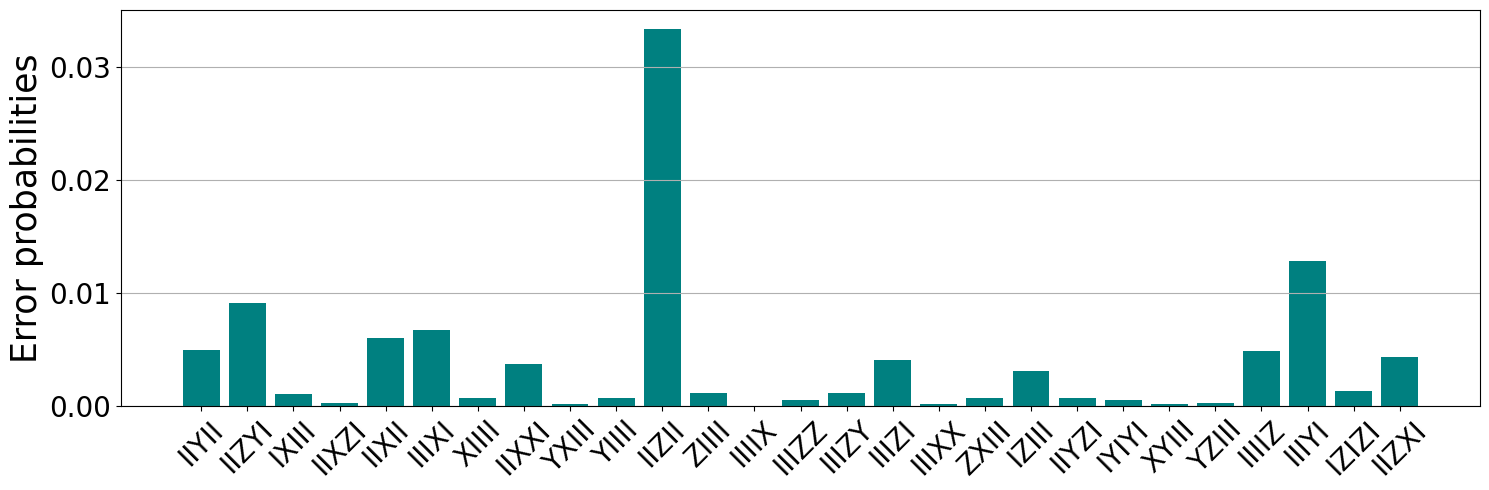

In [23]:
values=[]
for pauli, coeff in data:
    if coeff!=0:
        values.append(mf * coeff)

labels=[]
for pauli, coeff in data:
    if coeff!=0:
        labels.append(str(pauli))

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(labels, values, color="teal")

ax.set_ylabel("Error probabilities", fontsize=25)
ax.tick_params(axis='x', labelsize=20, labelrotation=45)
ax.tick_params(axis='y', labelsize=20)
ax.grid(axis='y')
plt.tight_layout()
# plt.savefig('lambda_coeff.pdf')



In [24]:
# Input SparsePauliOp
pauli_strings = ['IIIII', 'ZZIII', 'IZZII', 'IIZZI', 'IIIZZ']
coeffs = [-2.0 + 0.j, 0.5 + 0.j, 0.5 + 0.j, 0.5 + 0.j, 0.5 + 0.j]

# Convert SparsePauliOp to QuTiP operator
hp_qutip_op = 0
for pauli_string, coeff in zip(pauli_strings, coeffs):
    # Map string to operators
    operators = [pauli_map[char] for char in pauli_string]
    # Create the tensor product
    tensor_op = qt.tensor(*operators)
    # Multiply by the coefficient and add to the final operator
    hp_qutip_op += coeff.real * tensor_op


In [25]:
# Input SparsePauliOp
pauli_strings = ['YZIII', 'ZYIII', 'IYZII', 'IZYII', 'IIYZI', 'IIZYI', 'IIIYZ', 'IIIZY']
coeffs = [1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j, 1.0 + 0.j]

op_qutip_op = 0
for pauli_string, coeff in zip(pauli_strings, coeffs):
    operators = [pauli_map[char] for char in pauli_string]
    tensor_op = qt.tensor(*operators)
    op_qutip_op += coeff.real * tensor_op


In [26]:
pauli_strings = ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX']
coeffs = [1 + 0.j, 1 + 0.j, 1 + 0.j, 1 + 0.j, 1 + 0.j]

hd_qutip_op = 0
for pauli_string, coeff in zip(pauli_strings, coeffs):
    operators = [pauli_map[char] for char in pauli_string]
    tensor_op = qt.tensor(*operators)
    hd_qutip_op += coeff.real * tensor_op


In [27]:
gs_energy_qutip_op = hp_qutip_op.eigenstates()[0][0]
print(gs_energy_qutip_op)
gs_qutip_op = hp_qutip_op.eigenstates()[1][0]
rh_qutip_op = gs_qutip_op*gs_qutip_op.dag() 
init_state = tensor(plus, plus, plus, plus, plus)
# rh_qutip_op

-4.0


In [32]:
Ep1_now = []
rho = init_state
states = [init_state]
beta1_now = [0, 0]
final_state = [init_state*init_state.dag()]
h1_now = [0, 1]
stepsss = 20

for i in range(1, stepsss):
    beta_s = interp1d(times1[1:i+2], beta1_now, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[hp_qutip_op, coeff_beta(hamil_s, times1[1:i+2])], [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    result = mesolve(H_tot_2, init_state, times1[1:i+2], [], [op_qutip_op, hp_qutip_op])
    result_states = mesolve(H_tot_2, init_state, times1[1:i+2], [], [])

    beta = - result.expect[0][-1] 
    beta1_now.append(beta)
    h1_now.append(1)
    Ep1_now.append(result.expect[1][-1])

    state = result_states.states[-1]
    final_state.append(state*state.dag())

In [33]:
r_now = []
for i in range(len(Ep1_now)):
    r_now.append(Ep1_now[i]/gs_energy_qutip_op)
# app_ratio.append(np.array(r))

succ_prob_Ep1_now = []
for i in range(len(final_state)):
    succ_prob_Ep1_now.append(fidelity_qutip(rh_qutip_op, final_state[i]))

In [39]:
'''Just to verify if states have been normalized properly'''

normal = []
for i in range(len(final_state)):
    normal.append(fidelity_qutip(final_state[i], final_state[i]))

print(succ_prob_Ep_kasf1)

[1.0000000266182985, 1.0000000680444412, 1.0000000690459812, 1.0000000824250905, 1.0000000738778518, 1.0000000763072039, 1.000000078400405, 1.0000000721741142, 1.0000000719336248, 1.0000000663077153, 1.000000067072109, 1.0000000729226424, 1.0000000762417676, 1.0000000712921697, 1.0000000706200052, 1.0000000682382257, 1.0000000675615257, 1.0000000747091013, 1.0000000644438436, 1.000000073557785]


In [40]:
Ep_now_open = []
rho = init_state
states = [init_state]
beta1_now_open = [0, 0]
h1_now = [0, 1]
final_state_open = [init_state*init_state.dag()]

options = {"store_final_state": True} 

for i in range(1, stepsss):
    beta_s = interp1d(times1[1:i+2], beta1_now_open, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[hp_qutip_op, coeff_beta(hamil_s, times1[1:i+2])], [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    result = mesolve(H_tot_2, init_state, times1[1:i+2], c_ops, [op_qutip_op, hp_qutip_op], options= options)
    result_states = mesolve(H_tot_2, init_state, times1[1:i+2], c_ops, [])

    beta = - result.expect[0][-1] 
    beta1_now_open.append(beta)
    h1_now.append(1)
    Ep_now_open.append(result.expect[1][-1])

    state = result_states.states[-1]
    final_state_open.append(result.final_state)

    # final_state_open.append(state*state.dag())

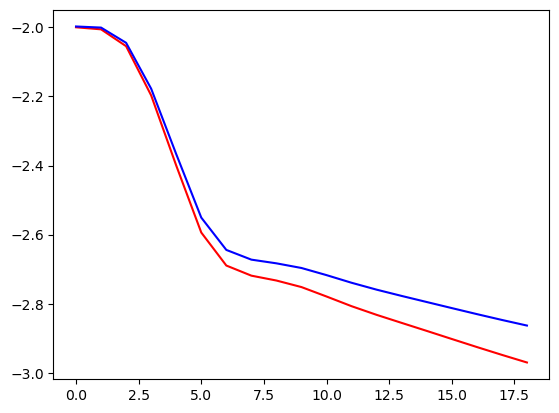

In [41]:
plt.plot(Ep1_now, 'r') 
plt.plot(Ep_now_open, 'b')

In [42]:
succ_prob_Ep_now_open = []
for i in range(len(final_state_open)):
    succ_prob_Ep_now_open.append(fidelity_qutip(rh_qutip_op, final_state_open[i]))

r_now_open = []
for i in range(len(Ep_now_open)):
    r_now_open.append(Ep_now_open[i]/gs_energy_qutip_op) 

In [44]:
ep_now_open_new = []
nomrls = []
for i in range(len(Ep_now_open)):
    # state_n = final_state_open[i]/(final_state_open[i].norm())
    # nomrls.append(state_n.norm()) 
    ep = qt.expect(hp_qutip_op, final_state_open[i])
    ep_now_open_new.append(ep)

### Open system with Lyapunov controlled gamma rates 

In [45]:
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        print(pauli_string, coeff)

IIYII 0.000495018435101417
IIZYI 0.0009148370101589832
IXIII 0.00010777432702382785
IIXZI 3.1545884368385507e-05
IIXII 0.0006046326001171507
IIIXI 0.0006719327585057008
XIIII 7.526607900406381e-05
IIXXI 0.00036838238141547255
YXIII 1.6817199893082228e-05
YIIII 6.985366946050551e-05
IIZII 0.0033398655383545996
ZIIII 0.00011313873615702958
IIIIX 3.937691265307485e-06
IIIZZ 5.825477241087637e-05
IIIZY 0.00011872906295227361
IIIZI 0.00041229446224651776
IIIXX 1.635814222551901e-05
ZXIII 7.466961284011499e-05
IZIII 0.00030888065469906155
IIYZI 6.780921625122265e-05
IYIYI 5.195981140560146e-05
XYIII 1.6072548931333763e-05
YZIII 2.3852560101057888e-05
IIIIZ 0.00048762385635260793
IIIYI 0.0012874721005326538
IZIZI 0.0001364588361555782
IIZXI 0.0004380108606459997


In [46]:
# Construct c_ops
# c_ops = 0
OPS = []
gamma_coeffs = []
pauli_strings = []

for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        second_lyapunov = tensor_op.dag() * hp_qutip_op * tensor_op - hp_qutip_op
        OPS.append(second_lyapunov)
        gamma_coeffs.append(coeff*mf)
        pauli_strings.append(tensor_op)

In [ ]:
Ep_kasf1 = []
gammv = [0, gamma_coeffs[0]]

rho = init_state
states = [init_state]
beta1_kasf1 = [0, 0]
h1_now = [0, 1]

e_ops = [op_qutip_op, hp_qutip_op, OPS[0]]
nmmc_options = {"map": "parallel"}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced", "store_final_state": True, "norm_tol" : 1e-6, "norm_steps": 50} 

cc = []
state_f = [init_state*init_state.dag()]
tr = []
ntraj = 100
th = 0.15 

num_traj = []

for i in range(1, 10):
    # print(i)
    beta_s = interp1d(times1[1:i+2], beta1_kasf1, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[hp_qutip_op, coeff_beta(hamil_s, times1[1:i+2])], [hd_qutip_op, coeff_beta(beta_s, times1[1:i+2])]]

    gamma_int = CubicSpline(times1[1:i+2], np.complex128(gammv))
    
    # c_ops = [[qt.tensor(si, sy, si), gamma_int]]
    c_ops = [[pauli_strings[0], gamma_int]]

    result = nm_mcsolve(H_tot_2, init_state, times1[1:i+2], c_ops, e_ops, ntraj = ntraj, options=(options | nmmc_options))

    beta = - result.expect[0][-1] 
    beta1_kasf1.append(beta)
    h1_now.append(1)

    b0 = result.expect[2][-1]
    if b0 > th:
        g0 = - th
    else:
        g0 = - b0

    # gammv.append(g0)
    gammv.append(g0)
    Ep_kasf1.append(result.expect[1][-1])

    tr.append(result.trace[-1])
    state_f.append(result.final_state)

    num_traj.append(result.num_trajectories)


 Total run time:   1.52s*] Elapsed 1.49s / Remaining 00:00:00:00
 Total run time:   0.97s*] Elapsed 0.93s / Remaining 00:00:00:00
 Total run time:   1.20s*] Elapsed 1.18s / Remaining 00:00:00:00
 Total run time:   1.10s*] Elapsed 1.08s / Remaining 00:00:00:00[*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00
 Total run time:   1.33s*] Elapsed 1.31s / Remaining 00:00:00:00[*********92%*********  ] Elapsed 1.08s / Remaining 00:00:00:00
 Total run time:   1.04s*] Elapsed 1.02s / Remaining 00:00:00:00
 Total run time:   1.18s*] Elapsed 1.15s / Remaining 00:00:00:00[*********77%******     ] Elapsed 0.88s / Remaining 00:00:00:00
 Total run time:   1.04s*] Elapsed 1.02s / Remaining 00:00:00:00
 Total run time:   1.29s*] Elapsed 1.26s / Remaining 00:00:00:00[*********89%********   ] Elapsed 1.17s / Remaining 00:00:00:00


In [321]:
result.stats

{'method': 'adams',
 'init time': 0.000247955322265625,
 'preparation time': 0.0039010047912597656,
 'run time': 1.294154167175293,
 'solver': 'Master Equation Evolution',
 'num_collapse': 1,
 'end_condition': 'ntraj reached'}

In [ ]:
succ_prob_Ep_kasf1 = []
for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(state_f[i], state_f[i]))

# (succ_prob_Ep_kasf1)

[1.0000000266182985,
 1.000000078219729,
 1.000000075429436,
 1.0004552811730045,
 1.0036622085278692,
 1.0178020763484865,
 1.0402984002549014,
 1.0622112466929752,
 1.0856563291819596,
 1.1084493991878015]

In [294]:
succ_prob_Ep_kasf1 = []
for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(state_f[i], state_f[i]))

(succ_prob_Ep_kasf1)

[1.0000000266182985,
 1.0000000699662956,
 1.000000071509667,
 1.0004552774050952,
 1.0036622120530287,
 1.0178020801933625,
 1.0421130065707875,
 1.0622112466135425,
 1.0856563384546678,
 1.108449402876147]

In [272]:
st = state_f[2]
st
qt.fidelity(st, st)

1.0000000650079637

In [288]:
tr

[1.0,
 1.0,
 1.0004552085891896,
 1.003662132016718,
 1.0178020018085763,
 1.0421129307109154,
 1.0622111752978503,
 1.0856562644441852,
 1.1084493241193891]

In [274]:
tr_new = []
for i in range(len(state_f)):
    tr_new.append(state_f[i].tr())


tr_new

[0.9999999999999998,
 1.0000000000000004,
 0.9999999999999998,
 1.0004552085891896,
 1.003662132016718,
 1.0178020018085763,
 1.0421129307109152,
 1.0622111752978496,
 0.868525011555348,
 1.1084493241193891]

In [ ]:
print(qt.expect(hp_qutip_op, final_state[-1]))
print(Ep1_now[-1])


print(qt.expect(hp_qutip_op, final_state_open[10]))
print(Ep_now_open[10])

print(qt.expect(hp_qutip_op, state_f[-1]))
print(Ep_kasf1[-1])

-2.969757445784028
-2.969757445784028
-2.696404870265329
-2.717034708093274
-2.703721919792109
-2.703721919792108


In [ ]:
print(fidelity_qutip(state_f[7], state_f[7]))
print(tr)

print(1/1.0101489799125636 * state_f[7].tr())

# tr = []
# for i in range(len(Ep_kasf1)):
#     tr.append()

1.062211237578598
[1.0, 1.0, 1.0004552085891882, 1.0036621320167176, 0.9974459617724045, 1.021270672096696, 0.9347458342621064, 0.9553775127108814, 0.9754354052250633]
0.9253544307326014


In [ ]:
st = state_f[8] / ((state_f[8]).norm())
print((state_f[8]).norm())
st.norm()


1.0856562644441887


1.0

In [ ]:
succ_prob_Ep_kasf1 = []

for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(rh_qutip_op, state_f[i]))

r_now_kasf1 = []
for i in range(len(Ep_kasf1)):
    r_now_kasf1.append(Ep_kasf1[i]/gs_energy_qutip_op)

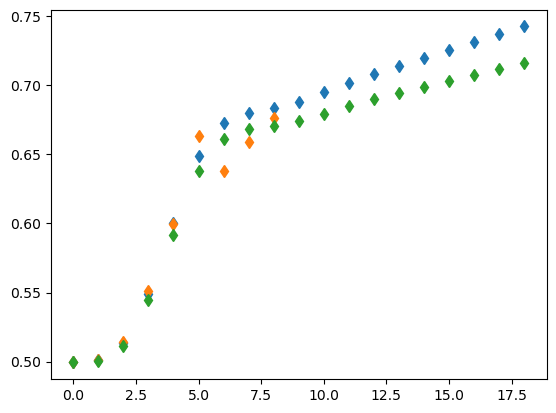

In [ ]:
k = 25
plt.plot(r_now[0:k],'d')
plt.plot(r_now_kasf1[0:k], 'd')
plt.plot(r_now_open[0:k],'d')


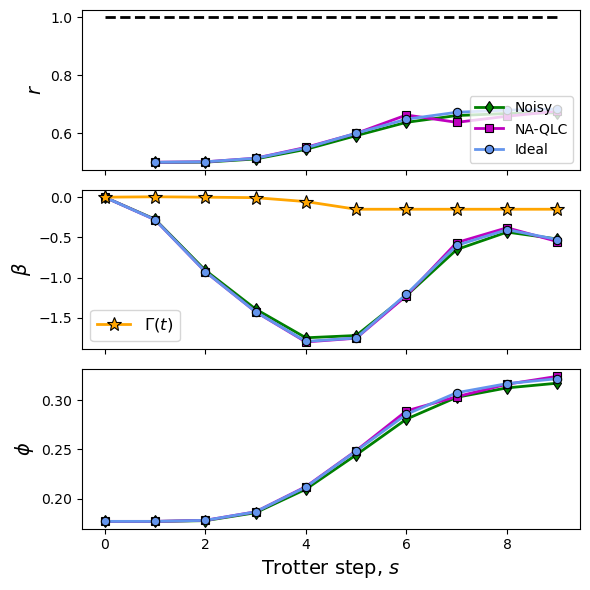

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

k = 9
x= np.arange(1, k+1)

axes[0].plot(x, r_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[0].plot(x, r_now_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
axes[0].plot(x, r_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
# axes[0].plot(tr)
axes[0].set_ylabel(r"$r$", fontsize=14)
axes[0].legend(fontsize=10, loc = 'lower right')
axes[0].tick_params(axis='x', labelsize=15)
# axes[0].legend()
# axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

axes[1].plot(beta1_now_open[1:k+2], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_kasf1[1:k+2], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_now[1:k+2], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(gammv[0:k+1], color = 'orange', marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\Gamma(t)$")

axes[1].legend(fontsize=12)
axes[1].set_ylabel(r"$\beta$", fontsize=14)
# axes[1].text(2.4, -0.35, "(b)", fontsize=10, fontweight='bold')


k = 10
axes[2].plot(succ_prob_Ep_now_open[0:k], color = 'g', marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
axes[2].plot(succ_prob_Ep_kasf1[0:k], color = 'm', marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-QLC')
axes[2].plot(succ_prob_Ep1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
# axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
# axes[2].legend()
axes[2].set_ylabel(r"$\phi$",fontsize=14)
axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
# axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
# filename = f"Maxcut_5q.pdf"  # Creates "plot_experiment1.png"
# filename = f"Plot1_dt_0.05_mf_5_ntraj_3000_type1_steps40.pdf"
# plt.savefig(filename)
plt.show()


In [41]:
k = 25
kasturi = [r_now_open[0:k], r_now_kasf1[0:k], r_now[0:k]]
file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'  

# Write the array to a file
np.save(file_path, kasturi)

In [42]:
k = k+1

kasturi = [succ_prob_Ep_now_open[0:k], succ_prob_Ep_kasf1[0:k], succ_prob_Ep1_now[0:k]]
file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [43]:
k = k+1
kasturi = [beta1_now_open[1:k], beta1_kasf1[1:k], beta1_now[1:k]]
file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [44]:
kasturi = gammv
file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [ ]:
kasturi = tr
file_path = f'data_5q/tr_mf_{mf}_dt_{dt}_ntraj_{ntraj}_th_{th}_type1.npy'

# Write the array to a file
np.save(file_path, kasturi)

## LOAD FILES AND PLOT

In [2]:
ntraj1 = 12000
mf = 10
dt = 0.07


file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
agp_arr = np.load(file_path)

r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
agp_arr3 = np.load(file_path)
succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
agp_arr2 = np.load(file_path)
beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type2.npy'
gammv = np.load(file_path)

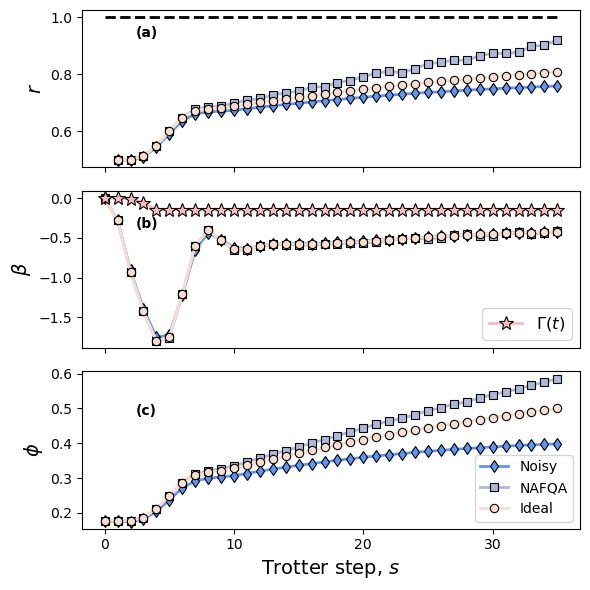

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

colors = ['#6495ED','#AEB9D7', '#F8DED1', '#F6BDC0']
# colors = ['g', 'm', '#6495ED', 'orange']

k = 35
x= np.arange(1, k+1)

axes[0].plot(x, r_now_open[0:k], color = colors[0], marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[0].plot(x, r_now_kasf1[0:k], color = colors[1], marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-FQA')
axes[0].plot(x, r_now[0:k], color = colors[2], marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
# axes[0].plot(tr)
axes[0].set_ylabel(r"$r$", fontsize=14)
# axes[0].legend(fontsize=10, loc = 'lower right')
axes[0].tick_params(axis='x', labelsize=15)
# axes[0].legend()
axes[0].text(2.4, 0.93, "(a)", fontsize=10, fontweight='bold')

axes[1].plot(beta1_now_open[0:k+1], color = colors[0], marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_kasf1[0:k+1], color =  colors[1], marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(beta1_now[0:k+1], color =  colors[2], marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
axes[1].plot(gammv[1:k+2], color = colors[3], marker = '*', markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = r"$\Gamma(t)$")

axes[1].legend(fontsize=12)
axes[1].set_ylabel(r"$\beta$", fontsize=14)
axes[1].text(2.4, -0.38, "(b)", fontsize=10, fontweight='bold')


k = 36
axes[2].plot(succ_prob_Ep_now_open[0:k], color =  colors[0], marker = 'd', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[2].plot(succ_prob_Ep_kasf1[0:k], color =  colors[1], marker = 's', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NAFQA')
axes[2].plot(succ_prob_Ep1_now[0:k], color =  colors[2], marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
# axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
axes[2].legend(fontsize=10, loc = 'lower right')
axes[2].set_ylabel(r"$\phi$",fontsize=14)
axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
axes[2].text(2.4, 0.48, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
filename = f"Maxcut_5q.pdf"  
# # filename = f"Plot1_dt_0.05_mf_5_ntraj_3000_type1_steps40.pdf"
plt.savefig(filename)
plt.show()


## Plot as a function of time 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


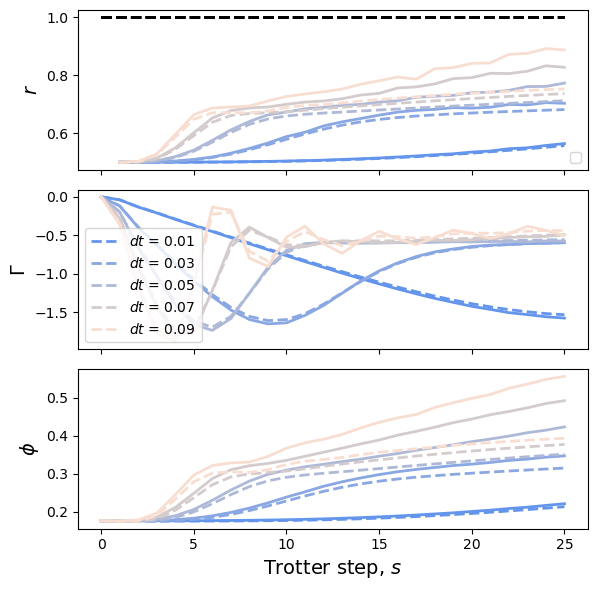

In [505]:
ntraj1 = 12000
mf = 10
# dt = 0.05

cases = [0.01, 0.03, 0.05, 0.07, 0.09]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

for i, dt in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[0].plot(x, r_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend()
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta1_now_open[0:k+1], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$dt$ = {dt}')
    axes[1].plot(beta1_kasf1[0:k+1], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[1].plot(beta1_now[0:k+1], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[1].plot(gammv[1:k+2], color =  colors[i], markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$dt$ = {dt}')

    axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\Gamma$", fontsize=14)
    # axes[1].text(2.4, -0.35, "(b)", fontsize=10, fontweight='bold')


    k = 26
    axes[2].plot(succ_prob_Ep_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-FQA')
    # axes[2].plot(succ_prob_Ep1_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Closed quatum system')
    # axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
# filename = f"demo_2.pdf" 
# plt.savefig(filename)
plt.show()


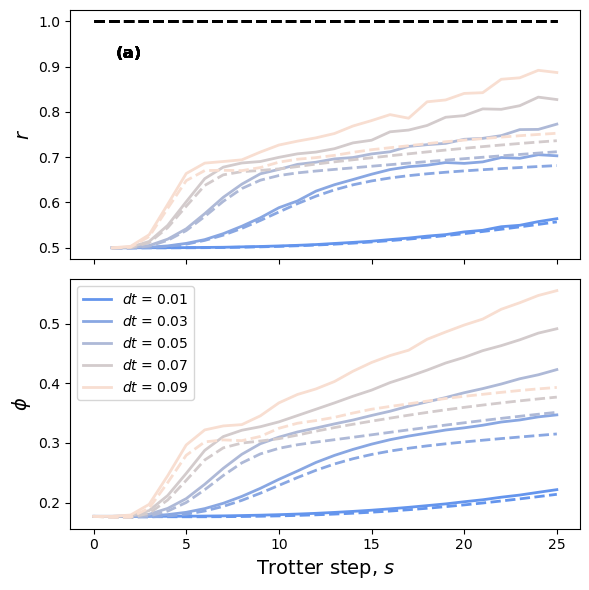

In [6]:
ntraj1 = 12000
mf = 10
# dt = 0.05

cases = [0.01, 0.03, 0.05, 0.07, 0.09]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for i, dt in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    axes[0].text(1.2, 0.92, "(a)", fontsize=12, fontweight='bold')
    axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[0].plot(x, r_now[0:k], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    # axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend()
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    k = 26
    axes[1].plot(succ_prob_Ep_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = f'$dt$ = {dt}')
    axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\phi$",fontsize=14)
    axes[1].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
filename = f"demo_2.pdf" 
plt.savefig(filename)
plt.show()


## Plot as a function of no. of samples

0
1
2
3
4


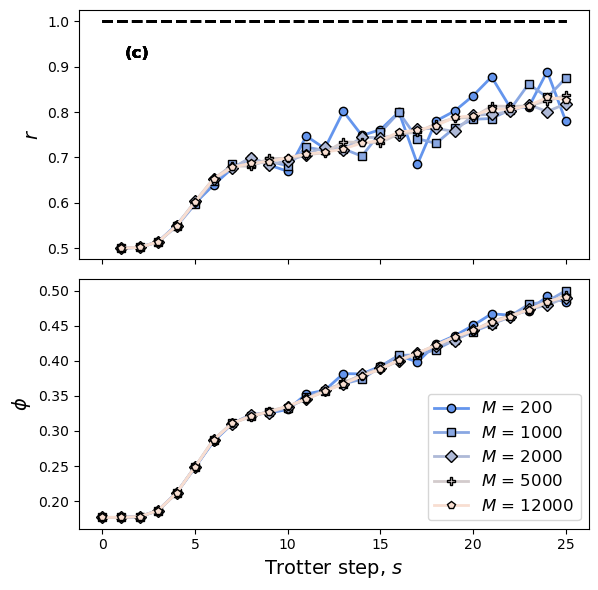

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm

mf = 10
dt = 0.07
ntraj = 500
nota = [200, 1000, 2000, 5000, 12000]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']
# colors = cm.viridis(np.linspace(0, 1, len(x)))

markers = ['o', 's', 'D', 'P', 'p', '1']

fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
k = 25

delta_t = [dt]

file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
gammv = np.load(file_path)

i = 0 
init = 0
x= np.arange(init+1, k+1)

for ntraj in nota:
    print(i)
    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'

    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]

    # file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    # agp_arr2 = np.load(file_path)
    # beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]

    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]


    # Subplot (a) ⟨Hp⟩
    axes[0].text(1.2, 0.92, "(c)", fontsize=12, fontweight='bold')
    axes[0].plot(x, r_kasf1[init:k],  color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-', linewidth=2, 
                markersize=6, markeredgewidth=1, markeredgecolor='black', label=f'$M$ = {ntraj}')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    axes[0].set_ylabel(r"$r$", fontsize=14)
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].text(1.2, 0.90, "(c)", fontsize=10, fontweight='bold')


    # axes[1].plot(beta_kasf1[init:k+1], color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-', linewidth=2, 
    #             markersize=6, markeredgewidth=1, markeredgecolor='black')
    # axes[1].set_ylabel(r"$\beta$", fontsize=14)

    axes[1].plot(succ_prob_kasf1[init:k+1], color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-', linewidth=2, 
                markersize=6, markeredgewidth=1, markeredgecolor='black', label=f'$M$ = {ntraj}')
    axes[1].set_ylabel(r"$\phi$",fontsize=14)
    axes[1].set_xlabel(r"Trotter step, $s$", fontsize=14)
    axes[1].legend(fontsize=12, loc='lower right')

    # axes[1].legend(loc = 'lower right', bbox_to_anchor=(2.15, -0.3), ncol = 5, fontsize=12)
    i += 1

# Adjust layout
plt.tight_layout()
filename = f"ntraj_demo.pdf" 
plt.savefig(filename)
plt.show()


## Plot as a function of thresold value

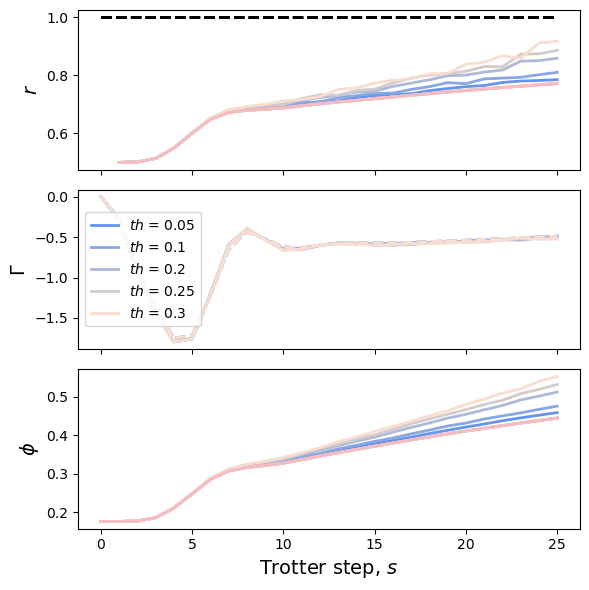

In [ ]:
ntraj1 = 12000
mf = 10
dt = 0.07

cases = [0.05, 0.1, 0.2, 0.25, 0.3]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

for i, th in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    

    # axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    # axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend()
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    axes[1].plot(beta1_now_open[0:k+1], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[1].plot(beta1_kasf1[0:k+1], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$th$ = {th}')
    # axes[1].plot(beta1_now[0:k+1], color = '#6495ED', marker = 'o', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    # axes[1].plot(gammv[1:k+2], color =  colors[i], markersize = '10', linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black',  label = f'$dt$ = {dt}')

    axes[1].legend(fontsize=10)
    axes[1].set_ylabel(r"$\Gamma$", fontsize=14)
    # axes[1].text(2.4, -0.35, "(b)", fontsize=10, fontweight='bold')


    k = 26
    # axes[2].plot(succ_prob_Ep_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Open quantum system')
    axes[2].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'NA-FQA')
    axes[2].plot(succ_prob_Ep1_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Closed quatum system')
    # axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
    # axes[2].legend()
    axes[2].set_ylabel(r"$\phi$",fontsize=14)
    axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')

plt.tight_layout()
# filename = f"demo_2.pdf" 
# plt.savefig(filename)
plt.show()


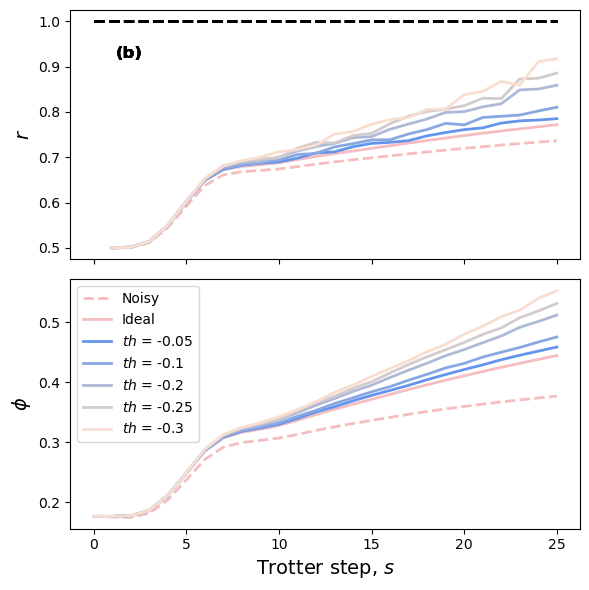

In [12]:
ntraj1 = 12000
mf = 10
dt = 0.07

cases = [0.05, 0.1, 0.2, 0.25, 0.3]
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']
# colors = ['blue', 'orange', 'g', 'purple', 'olive']


fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

th = 0.05

file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
agp_arr = np.load(file_path)

r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]

axes[0].plot(x, r_now_open[0:k], color = '#F6BDC0', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
axes[0].plot(x, r_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')


for i, th in enumerate(cases):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr = np.load(file_path)

    r_now_open, r_now_kasf1, r_now = agp_arr[0], agp_arr[1], agp_arr[2]


    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_Ep_now_open, succ_prob_Ep_kasf1, succ_prob_Ep1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    agp_arr2 = np.load(file_path)
    beta1_now_open, beta1_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]


    file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj1}_th_{th}_type1.npy'
    gammv = np.load(file_path)

    k = 25
    x= np.arange(1, k+1)

    axes[0].text(1.2, 0.92, "(b)", fontsize=12, fontweight='bold')
    # axes[0].plot(x, r_now_open[0:k], color = colors[i], linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black')
    axes[0].plot(x, r_now_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = f'$th$ = {-th}')
    # axes[0].plot(x, r_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')
    axes[0].plot([1]*(k+1),linestyle='--', linewidth=2, color = 'black')
    # axes[0].plot(tr)
    axes[0].set_ylabel(r"$r$", fontsize=14)
    # axes[0].legend(fontsize=10, loc = 'lower right')
    axes[0].tick_params(axis='x', labelsize=15)
    # axes[0].legend(fontsize = 10, loc = 'center left')
    # axes[0].text(2.4, 0.73, "(a)", fontsize=10, fontweight='bold')

    k = 26
    if i == 0:
        axes[1].plot(succ_prob_Ep_now_open[0:k], color = '#F6BDC0', linestyle='--', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = 'Noisy')
        axes[1].plot(succ_prob_Ep1_now[0:k], color = '#F6BDC0', linestyle='-', linewidth=2, label = 'Ideal')

    axes[1].plot(succ_prob_Ep_kasf1[0:k], color = colors[i], linestyle='-', linewidth=2, markeredgewidth=0.8, markeredgecolor='black', label = f'$th$ = {-th}')
    # axes[2].plot([1]*21,linestyle='--', linewidth=2, color = 'black')
    # axes[2].legend()
    axes[1].set_ylabel(r"$\phi$",fontsize=14)
    axes[1].set_xlabel(r"Trotter step, $s$", fontsize=14)
    axes[1].legend(fontsize = 10, loc = 'upper left')

    # axes[2].text(2.4, 0.38, "(c)", fontsize=10, fontweight='bold')


plt.tight_layout()
filename = f"demo_3.pdf" 
plt.savefig(filename)
plt.show()
